**IMPORTANTE**  
Este ejercicio está dividido en tres partes, esta es la parte número 1.  
Para ir a las otras partes:  
- [Parte 1](Parte1_PCA1COMPONENTE.ipynb)
- [Parte 3 y conclusiones](Parte3_LDA1COMPONENTE_y_Conclusiones.ipynb)


In [1]:
from sklearn import datasets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

## Carga de datos

## Exploración de datos

In [2]:
# Datos en bruto
df_titanic = pd.read_csv('titanic_dataset.csv', index_col='PassengerId')

In [3]:
df_titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Este dataset de Kaggle, no tiene txt con la información. Voy a copiarla directamente de la página web para tenerla en cuenta.  
Fuente https://www.kaggle.com/competitions/titanic/data?select=train.csv

survival	Survival	0 = No, 1 = Yes  
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex	Sex  
Age	Age in years  
sibsp	# of siblings / spouses aboard the Titanic  
parch	# of parents / children aboard the Titanic  
ticket	Ticket number  
fare	Passenger fare  
cabin	Cabin number  
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [4]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Eliminamos la columna Cabin, Ticket y Name porque no harán falta

In [5]:
df_titanic.drop('Cabin', axis = 1, inplace=True)
df_titanic.drop('Ticket', axis = 1, inplace=True)
df_titanic.drop('Name', axis = 1, inplace=True)

Convetimos survived a variable booleana.

In [6]:
df_titanic['Survived'] = df_titanic['Survived'].astype('bool')

Eliminamos los nulos

In [7]:
df_titanic.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [8]:
df_titanic.dropna(inplace=True)

Vemos si hay atipicos

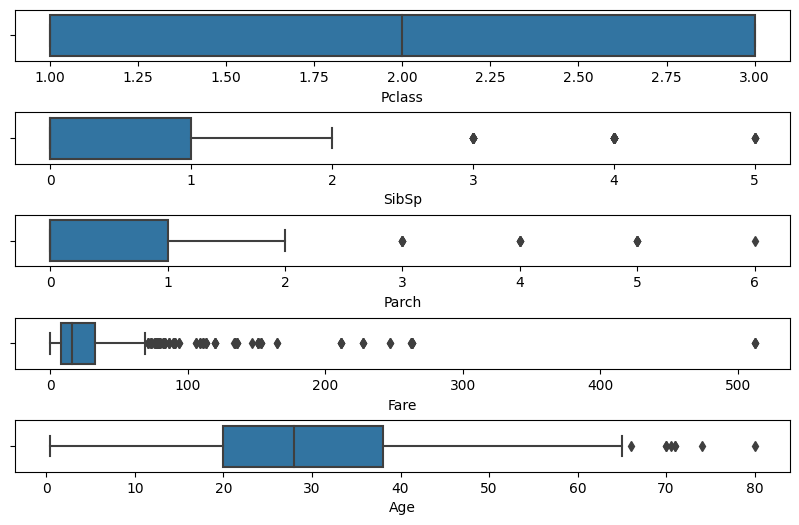

In [9]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,6))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['Pclass', 'SibSp', 'Parch','Fare','Age']):
    sns.boxplot(x=col, data=df_titanic, ax=ax[i])

Observamos que SibSp y Parch tienen muchos atípicos.  
Vamos a hacer que estas variables sean siempre 2 en caso de que el tripulante tenga más de un acompañante

In [10]:
sibsp_trans= lambda x: 2 if x >= 2 else x
df_titanic['SibSp'] = df_titanic['SibSp'].apply(sibsp_trans)
parc_trans= lambda x: 2 if x >=2 else x
df_titanic['Parch'] = df_titanic['Parch'].apply(sibsp_trans)

Corregimos atipicos en fare y age

In [11]:
variablerecorte = df_titanic[['Fare']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que cree un dataset sin los atipicos
df_titanic['Fare'] = df_titanic['Fare'].apply(
        lambda x: iqr_lim_sup if x > iqr_lim_sup else (iqr_lim_inf if x < iqr_lim_inf else x))

In [12]:
variablerecorte = df_titanic[['Age']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que cree un dataset sin los atipicos
df_titanic['Age'] = df_titanic['Age'].apply(
        lambda x: iqr_lim_sup if x > iqr_lim_sup else (iqr_lim_inf if x < iqr_lim_inf else x))

Comprobamos el resultado

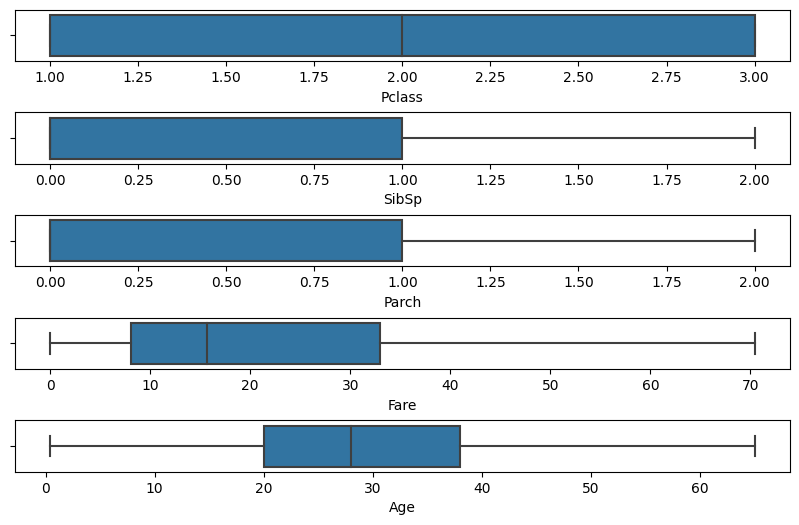

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10,6))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['Pclass', 'SibSp', 'Parch','Fare','Age']):
    sns.boxplot(x=col, data=df_titanic, ax=ax[i])

### Variables dummy

In [14]:
#Sex
Sex_dummies = pd.get_dummies(df_titanic['Sex'], prefix='Sex')
df_titanic.drop('Sex', axis = 1, inplace=True)
df_titanic = df_titanic.join(Sex_dummies)

#CryoSleep
Embarked_dummies = pd.get_dummies(df_titanic['Embarked'], prefix='Embarked')
df_titanic.drop('Embarked', axis = 1, inplace=True)
df_titanic = df_titanic.join(Embarked_dummies)

In [15]:
df_titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,False,3,22.0,1,0,7.250,False,True,False,False,True
2,True,1,38.0,1,0,70.425,True,False,True,False,False
3,True,3,26.0,0,0,7.925,True,False,False,False,True
4,True,1,35.0,1,0,53.100,True,False,False,False,True
5,False,3,35.0,0,0,8.050,False,True,False,False,True


In [16]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1 to 891
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    712 non-null    bool   
 1   Pclass      712 non-null    int64  
 2   Age         712 non-null    float64
 3   SibSp       712 non-null    int64  
 4   Parch       712 non-null    int64  
 5   Fare        712 non-null    float64
 6   Sex_female  712 non-null    bool   
 7   Sex_male    712 non-null    bool   
 8   Embarked_C  712 non-null    bool   
 9   Embarked_Q  712 non-null    bool   
 10  Embarked_S  712 non-null    bool   
dtypes: bool(6), float64(2), int64(3)
memory usage: 53.7 KB


Vamos a crearnos solo una variable que tome True si se trata de una mujer  
(Elegimos ese sexo puesto que las mujeres tenían preferencia en los botes salvavidas)

In [17]:
df_titanic.drop('Sex_male', axis = 1, inplace=True)

Vamos a ver si podemos eliminar alguna variable en Embarked

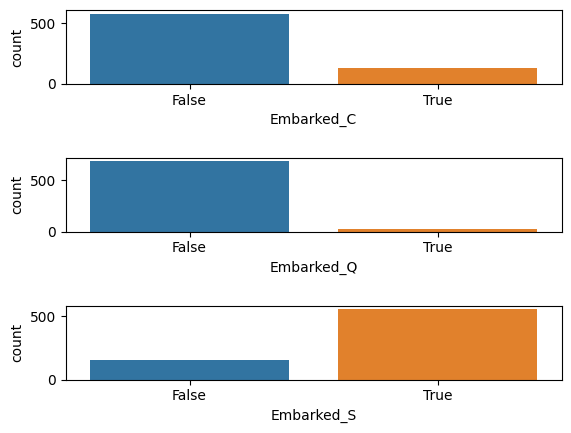

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=1)
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['Embarked_C','Embarked_Q','Embarked_S']):
  sns.countplot(x=col, data=df_titanic, ax=ax[i])
  ax[i].set_xticklabels(ax[i].get_xticklabels())

Como la mayoría embarcaron en Southampton, vamos a quedarnos solo con una variable que tome true si embarcaron en Southampton y false si embarcaron en otro sitio.

In [19]:
df_titanic.drop('Embarked_C', axis = 1, inplace=True)
df_titanic.drop('Embarked_Q', axis = 1, inplace=True)

In [20]:
df_titanic

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Embarked_S
PassengerId,,,,,,,,
1,False,3,22.0,1,0,7.250,False,True
2,True,1,38.0,1,0,70.425,True,False
3,True,3,26.0,0,0,7.925,True,True
4,True,1,35.0,1,0,53.100,True,True
5,False,3,35.0,0,0,8.050,False,True
...,...,...,...,...,...,...,...,...
886,False,3,39.0,0,2,29.125,True,False
887,False,2,27.0,0,0,13.000,False,True
888,True,1,19.0,0,0,30.000,True,True


## Exploración de datos

Vemos que columnas tenemos

In [21]:
print(df_titanic.keys())

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Embarked_S'],
      dtype='object')


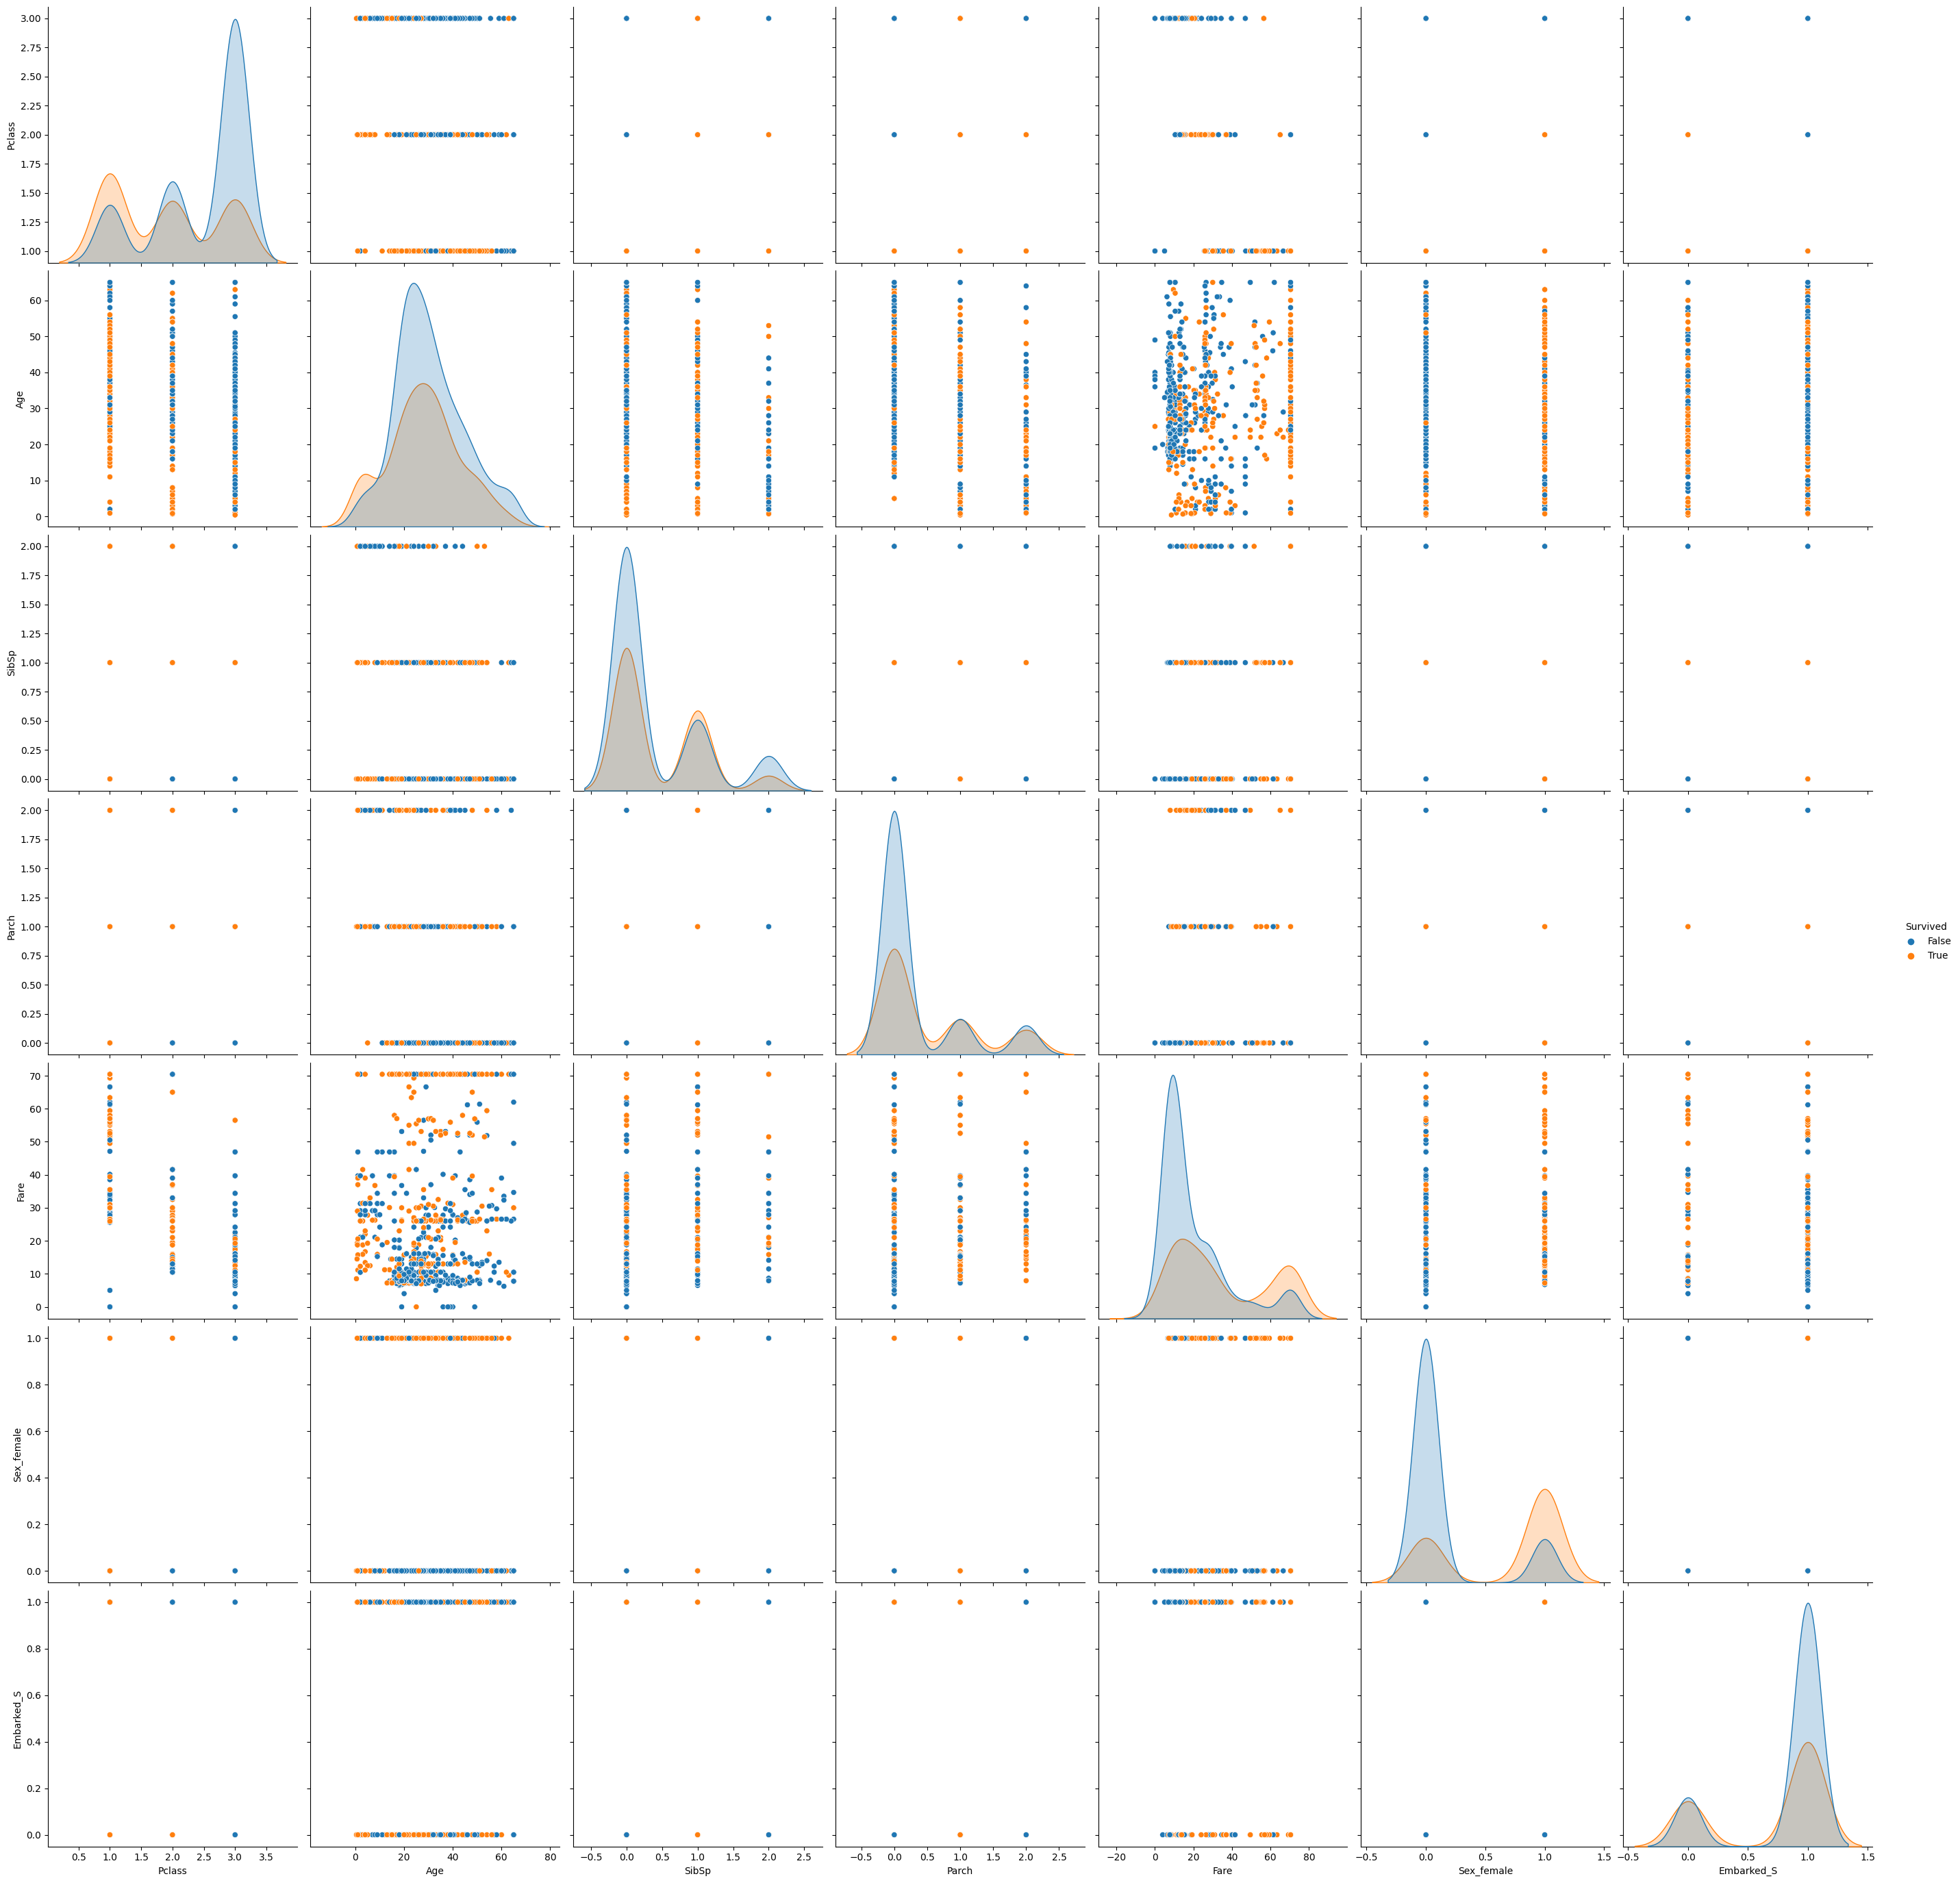

In [22]:
# Otros tipos de gráficos
sns.pairplot(df_titanic, hue='Survived', height=4, palette='tab10')
plt.show()

# PCA 2 Componentes

## Preprocesamiento de datos
### Selección de datos

In [23]:
# Seleccionamos las características a tener en cuenta para crear el modelo
X = df_titanic.drop('Survived', axis=1)

# Defino los datos correspondientes a las etiquetas
y = df_titanic['Survived']

## División de datos (conjuntos de entrenamiento y de prueba)

In [24]:
# Dividimos los datos de "entrenamiento" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Dividimos los datos de entrenamiento en desarrollo y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [25]:
X_plot = X_train.copy()
X_plot['Survived'] = y_train


### Normalización de los datos
#### MinMaxScaler

In [26]:
mmx = MinMaxScaler()
X_train_mmx = mmx.fit_transform(X_train)
X_test_mmx = mmx.transform(X_test)

In [27]:
X_plot = pd.DataFrame(X_train_mmx, columns=X_plot.columns[:-1], index=X_plot.index)
X_plot['Survived'] = y_train

### StandardScaler

In [28]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [29]:
X_plot = pd.DataFrame(X_train, columns=X_plot.columns[:-1], index=X_plot.index)
X_plot['Survived'] = y_train

In [30]:
# Utilizamos todas las características
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [31]:
# Exploramos la varianza que produce cada una de las variables
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.30515785, 0.26644439, 0.13582609, 0.12139048, 0.07444268,
       0.07339143, 0.02334708])

Como vimos que PCA de un componente no nos daba mucha información,  amos a intentar realizar un modelo de dos componentes.

In [32]:
pca = PCA(n_components=2) # 0.81
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [33]:
pca.explained_variance_ratio_

array([0.30515785, 0.26644439])

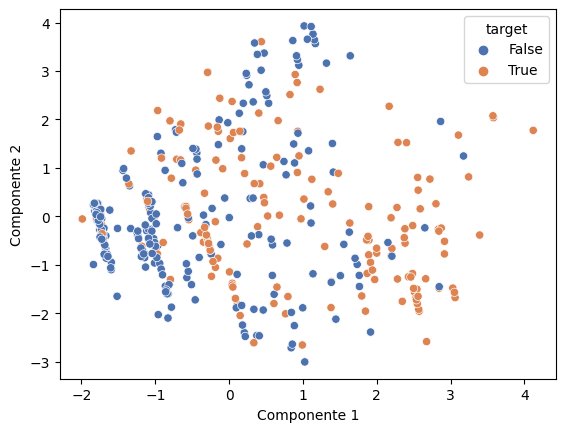

In [34]:
X_plot = pd.DataFrame(X_train, columns=['Componente 1', 'Componente 2'], index=X_plot.index)
X_plot['y'] = 0
X_plot['target'] = y_train

sns.scatterplot(x='Componente 1', y='Componente 2', data=X_plot, hue='target', palette='deep')
plt.show()

#### Creación del modelo

In [35]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

#### Predicción del modelo

In [36]:
y_pred = classifier.predict(X_test)

#### Validación de resultados

In [37]:
df_res = pd.DataFrame(columns=['Valor Real', 'Valor Predicho'])
df_res['Valor Real'] = y_val
df_res['Valor Predicho'] = y_pred
df_res['Acierto'] = (df_res['Valor Predicho']) == (df_res['Valor Real'])
df_res.head()

,Valor Real,Valor Predicho,Acierto
PassengerId,,,
148,False,True,False
246,False,False,True
478,False,True,False
633,True,False,False
361,False,False,True


#### Evaluación del modelo

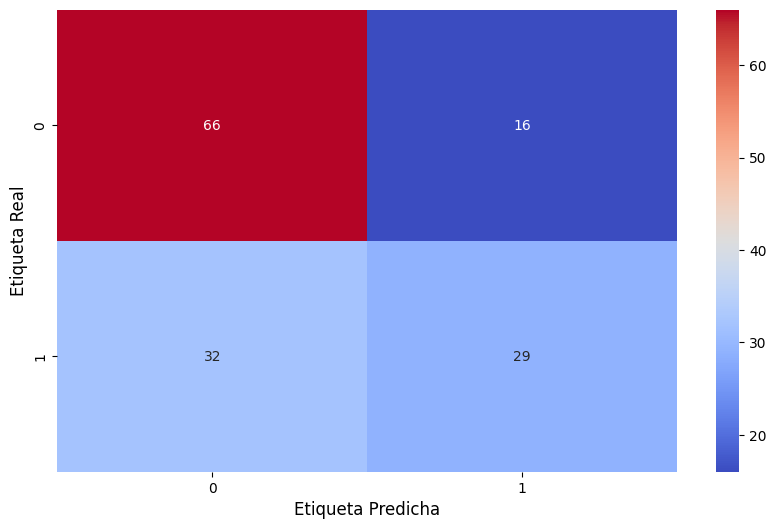

In [38]:
# Matriz de confusión
cf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,6))
shm = sns.heatmap(cf_matrix, annot=True, cmap='coolwarm', ax=ax)
shm.set_xlabel('Etiqueta Predicha', fontsize=12)
shm.set_ylabel('Etiqueta Real', fontsize=12)
plt.show()

In [39]:
# Métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.67      0.80      0.73        82
        True       0.64      0.48      0.55        61

    accuracy                           0.66       143
   macro avg       0.66      0.64      0.64       143
weighted avg       0.66      0.66      0.65       143



Añadiendo dos componentes, el modelo ha mejorado bastante, no obstante, vamos a probar con un modelo lda a ver si nos da más información